In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os
from scipy.signal import welch

Cargamos los datos:

In [2]:
eeg1 = pd.read_csv("participantes/eeg_pp_19.csv")

features1 = pd.read_csv("participantes/eeg_features_19.csv")

In [12]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00043,16.257530,19.381170,22.219890,8.075038,38.19235,7.317115,10.953730,23.370320,18.467050,28.638890,5.975503,5.514259,17.999450,14.770640,5.760747,-16.243530,-133.72920,-10.315300,-42.97229
1,0.00434,10.362130,14.674000,11.591040,5.350030,19.12668,10.192170,13.122280,4.615217,3.061107,1.773701,9.662848,-0.839316,1.754560,-1.888699,-7.591200,-18.102680,-49.49873,-10.839250,-22.27298
2,0.00825,8.532407,9.516185,7.775311,7.078826,10.47135,8.139617,10.871140,0.254097,-2.937233,-3.110588,9.262528,-1.375441,-2.386933,-5.606293,-8.654494,-14.237890,-17.59596,-8.319342,-11.91948
3,0.01215,8.581047,6.806276,10.257120,7.565037,19.05676,2.638346,7.819021,-5.118055,0.996137,2.370739,4.343142,-2.420250,-1.720073,-2.073024,-3.812862,-9.944178,-23.68761,-6.280297,-10.37151
4,0.01606,8.215273,7.556817,10.206410,3.424354,30.76206,-1.182850,8.071120,-18.773200,6.370045,-2.420103,-0.419681,-3.889801,-5.805663,-3.186094,-5.787561,-12.495390,-22.82613,-8.259068,-10.67694


In [23]:
len(eeg1), len(features1)

(103936, 2330)

In [24]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [25]:
features1['Binary_Trust'].value_counts(dropna=False)

Binary_Trust
high_trust    1800
NaN            330
low_trust      200
Name: count, dtype: int64

In [3]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [ ]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Comprobamos si hay valores sin éocas
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_37388\1576416167.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'high_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 31998 de un total de 103936

Distribución Binary_Trust:
Binary_Trust
high_trust    62140
NaN           31998
low_trust      9798
Name: count, dtype: int64

Distribución Trust:
Trust
4.0    62140
NaN    31998
2.0     7726
1.0     2072
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [ ]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 71938

Distribución Binary_Trust:
Binary_Trust
high_trust    62140
low_trust      9798
Name: count, dtype: int64

Distribución Trust:
Trust
4.0    62140
2.0     7726
1.0     2072
Name: count, dtype: int64


Observamos la distribución de los datos para ver si hay desbalance

C:\Users\crist\AppData\Local\Temp\ipykernel_37388\3394219416.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


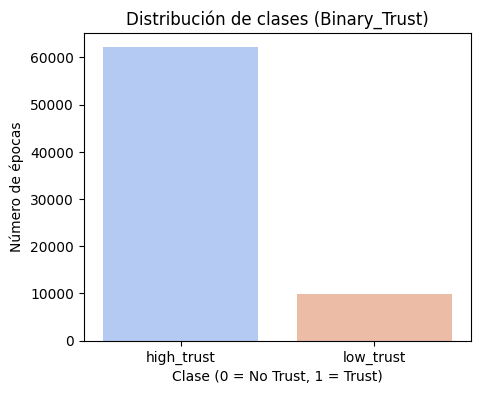

Distribución porcentual:
 Binary_Trust
high_trust    0.863799
low_trust     0.136201
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm')
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Almacén de los datos

Para almacenar los valores de f1_score durante la etapa de entrenamiento

In [ ]:
def save_f1_history(clf, architecture, participant):
    f1_curve = clf.history_[:, 'f1_macro']
    df_new = pd.DataFrame({
        'epoch': range(1, len(f1_curve)+1),
        'f1': f1_curve,
        'architecture': architecture,
        'participant': participant
    })

    filename = "historial_f1_global.csv"

    if os.path.exists(filename):
        df_old = pd.read_csv(filename)
        df_final = pd.concat([df_old, df_new], ignore_index=True)
    else:
        df_final = df_new

    df_final.to_csv(filename, index=False)
    print(f"Guardado en {filename}")


## Red Neuronal EEGNet

In [7]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [33]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 256.4068957084853


### Focal Loss

In [9]:
import torch.nn as nn
import torch.nn.functional as F
# Es una función de pérdida que nos sirve para clases desbalanceadas
# gamma controla cuánto penaliza la pérdida

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = (1 - pt) ** self.gamma * CE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [ ]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list, trial_ids = [], [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)
            trial_ids.append(trial)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor, np.array(trial_ids)

X_train_t, y_train_t, train_ids = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t, valid_ids = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t,  test_ids  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




C:\Users\crist\AppData\Local\Temp\ipykernel_37388\3465283698.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_tensor = torch.tensor(X_list, dtype=torch.float32)


torch.Size([621, 19, 256]) torch.Size([621])


### Selección de características

#### Métodos de filtro

In [ ]:
# Selección de canales (ANOVA) 
from sklearn.feature_selection import f_classif

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 
k = 10  
selected_channels = np.argsort(F_values)[-k:]  
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [12  7 15  6  2 11  1  4  5 10]
Nueva forma de X_train: torch.Size([621, 10, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [ 7  8 10  5  2 17  4 16 12 14]
Nueva forma de X_train: torch.Size([621, 10, 256])


#### Método híbrido (filter+wrapper)

In [249]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)

Canales finales (híbrido): [ 3 13  9 18  7  8  2 17 16 12]


#### Normalización

In [ ]:
mean = X_train_t.mean(dim=(0,2), keepdim=True)  
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


#### Oversampling

In [ ]:
# Convertir etiquetas a numpy 
y_np = y_train_t.cpu().numpy() if torch.is_tensor(y_train_t) else y_train_t

# Contar ejemplos por clase
counts = np.bincount(y_np)
majority_class = np.argmax(counts)
minority_class = 1 - majority_class

# Índices de cada clase
idx_majority = np.where(y_np == majority_class)[0]
idx_minority = np.where(y_np == minority_class)[0]

# Oversampling
idx_minority_upsampled = np.random.choice(idx_minority, size=len(idx_majority), replace=True)

# Combinar y mezclar
indices_balanced = np.concatenate([idx_majority, idx_minority_upsampled])
np.random.shuffle(indices_balanced)

# Crear los nuevos conjuntos
X_train_bal = X_train_t[indices_balanced]
y_train_bal = y_train_t[indices_balanced]

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 1010
Distribución balanceada: tensor([505, 505])


#### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

X_np = X_train_t.cpu().numpy().reshape(X_train_t.shape[0], -1)
y_np = y_train_t.cpu().numpy()

# Aplicar SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_res, y_res = smote.fit_resample(X_np, y_np)

# Volver a tensores con la misma forma original
X_train_bal = torch.tensor(X_res, dtype=torch.float32).reshape(-1, *X_train_t.shape[1:])
y_train_bal = torch.tensor(y_res, dtype=torch.long)

print("Nuevo tamaño:", len(y_train_bal))
print("Distribución balanceada:", torch.bincount(y_train_bal))


Nuevo tamaño: 1010
Distribución balanceada: tensor([505, 505])


In [41]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [80]:
df_train.groupby('epoch').size()


epoch
5.0      1120
6.0       208
7.0        50
8.0       479
10.0     1068
         ... 
218.0     639
219.0     374
221.0      50
222.0     217
224.0     400
Length: 128, dtype: int64

In [99]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 621
Valid windows: 210
Test windows: 211


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 19  
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.6,
    F1=8,F2=16,
)

In [19]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.3, gamma=2, reduction='mean')

#### Entrenamiento del modelo

In [ ]:
from skorch.callbacks import EarlyStopping, EpochScoring
from torch.utils.data import WeightedRandomSampler

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='recall_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

recall_macro = EpochScoring(
    scoring='recall_macro',  
    lower_is_better=False,
    on_train=False,
    name='recall_macro',
)


valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-4,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [21]:
# clf.fit(X_train_t, y_train_t)
clf.fit(X_train_bal, y_train_bal)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4152        0.7648       0.4333        0.6954  1.8877
      2      0.3912        0.7511       0.3952        0.6976  1.2855
      3      0.3476        0.7375       0.3476        0.7000  1.4487
      4      0.3032        0.7199       0.3048        0.7024  1.6825
      5      0.3007        0.6937       0.3048        0.7049  1.0466
      6      0.2846        0.6928       0.2905        0.7078  1.0912
      7      0.2846        0.6627       0.2905        0.7107  1.2432
      8      0.2900        0.6583       0.2952        0.7139  1.0714
      9      0.2954        0.6558       0.3000        0.7171  1.0660
     10      0.3060        0.6345       0.3095        0.7208  1.1891
     11      0.3060        0.6246       0.3095        0.7249  1.1226
     12      0.3017        0.6196       0.3048        0.7290  1.0586
     13      0.2973        0.6082 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 19, 256]              [1, 19, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 19, 256]           [1, 8, 19, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 19, 257]           [1, 8, 19, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 19, 257]           [1, 16, 1, 257]           --                        [19, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 19, 1]            304                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 20   7]
 [125  59]]
              precision    recall  f1-score   support

           0       0.14      0.74      0.23        27
           1       0.89      0.32      0.47       184

    accuracy                           0.37       211
   macro avg       0.52      0.53      0.35       211
weighted avg       0.80      0.37      0.44       211



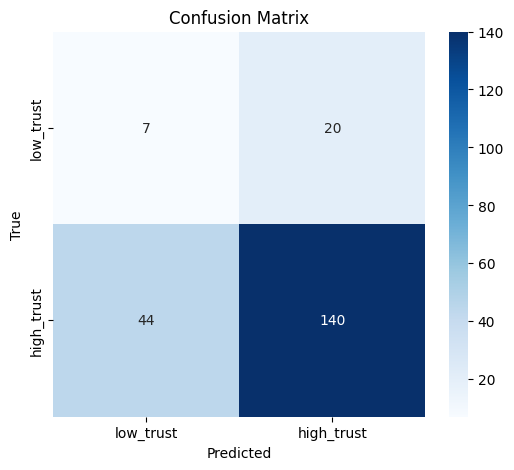

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.517


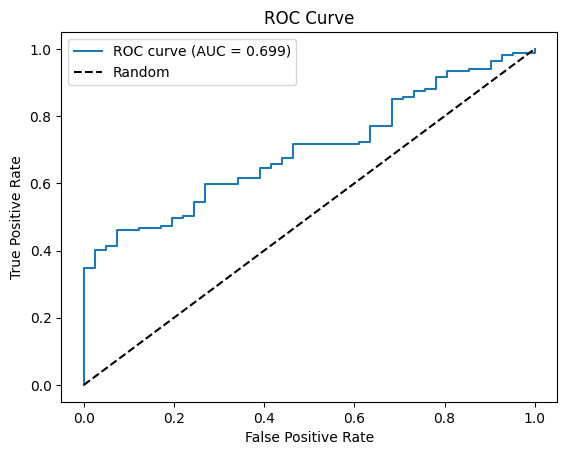

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Almacenamos los valor de f1-score

In [154]:
save_f1_history(
    clf=clf,
    architecture="EEGNet",
    participant="P19"
)

Guardado en historial_f1_global.csv


## RED NEURONAL EEGNeX

In [11]:
from braindecode.models import EEGNeX

In [ ]:
chans = 19   
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [ ]:
class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha=0.4, gamma=2, reduction='mean')

In [ ]:
f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False)

early_stopping = EarlyStopping(
    monitor='recall_macro',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

recall_macro = EpochScoring(
    scoring='recall_macro',  
    lower_is_better=False,
    on_train=False,
    name='recall_macro',
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[f1_macro],
    max_epochs=30,
    device='cpu',
)


In [27]:
clf.fit(X_train_t, y_train_t)
# clf.fit(X_train_bal, y_train_bal)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4678        0.6876       0.7286        0.6765  8.2606
      2      0.2864        0.6280       0.3000        0.7794  7.5744
      3      0.3131        0.5851       0.3333        0.8277  9.6182
      4      0.3269        0.5523       0.3714        0.8070  7.7080
      5      0.4145        0.5193       0.4952        0.7348  8.1398
      6      0.3802        0.4938       0.4571        0.8267  9.3433
      7      0.3354        0.4886       0.3952        0.8131  9.6635
      8      0.3956        0.4352       0.4667        0.7518  10.1163
      9      0.4269        0.4176       0.5000        0.8124  10.5863
     10      0.3619        0.4050       0.5095        0.8710  10.6363
     11      0.4486        0.3770       0.5476        0.9132  10.8099
     12      0.3713        0.3662       0.5000        0.9939  10.6939
     13      0.4518        0.

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [28]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas con sklearn
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[  1  26]
 [ 41 143]]
              precision    recall  f1-score   support

           0       0.02      0.04      0.03        27
           1       0.85      0.78      0.81       184

    accuracy                           0.68       211
   macro avg       0.43      0.41      0.42       211
weighted avg       0.74      0.68      0.71       211



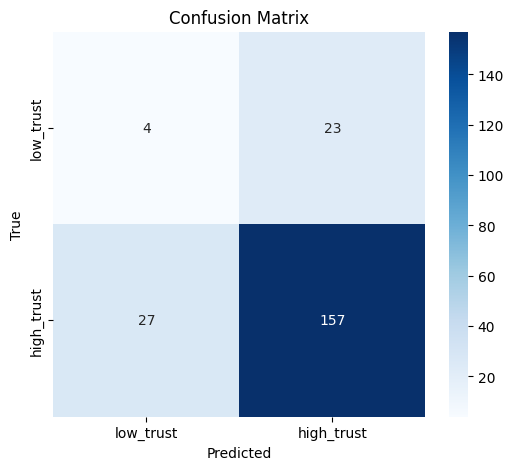

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.485


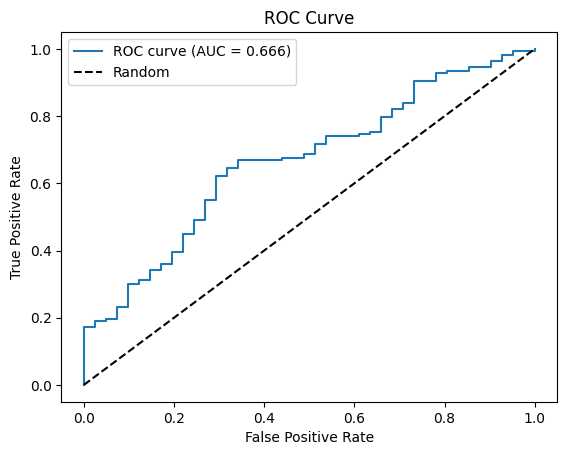

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [163]:
save_f1_history(
    clf=clf,
    architecture="EEGNeX",
    participant="P19"
)

Guardado en historial_f1_global.csv


## AttentionBaseNet

In [31]:
from braindecode.models import AttentionBaseNet


In [33]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.25,
    drop_prob_attn= 0.5,

)


In [34]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# criterion = FocalLoss(alpha= 0.7, gamma=1.5)

In [ ]:
f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[ 
               f1_macro,],
    max_epochs=30,
    device='cpu',
)


In [36]:
clf.fit(
    X_train_bal, 
    y_train_bal, 
)

  epoch    f1_macro    train_loss    valid_acc    valid_loss     dur
-------  ----------  ------------  -----------  ------------  ------
      1      0.4468        0.6917       0.4524        0.7025  1.7548
      2      0.4531        0.5979       0.4571        0.7325  1.3451
      3      0.3851        0.5155       0.3952        0.8825  1.3093
      4      0.3857        0.4600       0.4048        0.9620  1.3076
      5      0.4100        0.4139       0.4190        1.0039  2.9718
      6      0.4182        0.3638       0.4286        1.0166  3.5543
      7      0.4667        0.3202       0.4762        0.9605  3.6209
      8      0.4694        0.2884       0.4810        0.9253  3.2955
      9      0.4986        0.2658       0.5095        0.9762  3.5302
     10      0.4348        0.2193       0.4381        1.0351  3.3594
     11      0.5652        0.2104       0.5810        0.7338  3.4670
     12      0.6219        0.1767       0.6810        0.5456  3.7162
     13      0.6818        0.1536 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[ 16  11]
 [ 48 136]]
              precision    recall  f1-score   support

           0       0.25      0.59      0.35        27
           1       0.93      0.74      0.82       184

    accuracy                           0.72       211
   macro avg       0.59      0.67      0.59       211
weighted avg       0.84      0.72      0.76       211



Calculamos el ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1] 
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.746


Almacenamos el historial del f1_score durante el entrenamiento para su posterior visualización para los modelos base

In [179]:
save_f1_history(
    clf=clf,
    architecture="AttentionBaseNet",
    participant="P19"
)

Guardado en historial_f1_global.csv


## Análisis del espectro de la señal

In [ ]:
def build_trial_matrix(df):
    trials = df['epoch'].unique()

    X_trials = []
    y_trials = []

    bad_trials = []

    for trial in trials:
        trial_df = df[df['epoch'] == trial]

        # Eliminar columnas no EEG
        trial_df = trial_df.drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')

        signal = trial_df.values.T  

        # Revisar forma mínima
        if len(signal.shape) != 2:
            bad_trials.append((trial, signal.shape))
            continue

        # Revisar si hay más de 1 sample
        if signal.shape[1] < 20:  # señal demasiado corta = corrupta
            bad_trials.append((trial, signal.shape))
            continue

        # Etiqueta
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        y_bin = 0 if label == 'low_trust' else 1

        X_trials.append(signal)
        y_trials.append(y_bin)

    print("Trials corruptos detectados:", bad_trials)

    return X_trials, np.array(y_trials)


In [40]:
X_trials, y_trials = build_trial_matrix(eeg1)


Trials corruptos detectados: []


In [41]:
def normalize_trial_lengths(X_trials):
    Lmin = min(x.shape[1] for x in X_trials)
    X_cut = [x[:, :Lmin] for x in X_trials]
    return X_cut


In [49]:
from scipy.signal import welch

def psd_trials(X_trials, y_trials, sfreq=256):
    classes = np.unique(y_trials)
    psd_class = {}

    for cls in classes:
        trials = [X_trials[i] for i in range(len(X_trials)) if y_trials[i] == cls]

        psds = []
        for trial in trials:
            f, Pxx = welch(trial, sfreq, axis=1, nperseg=sfreq*2)
            psds.append(Pxx.mean(axis=0))

        psd_class[cls] = np.mean(psds, axis=0)

    plt.figure(figsize=(10,5))
    for cls in classes:
        plt.plot(f, psd_class[cls], label=f"Clase {cls}")
    plt.legend()
    plt.title(f"PSD por clase")
    plt.xlabel("Hz")
    plt.show()


Trials corruptos detectados: []


c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:790: UserWarning: nperseg = 512 is greater than input length  = 50, using nperseg = 50
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


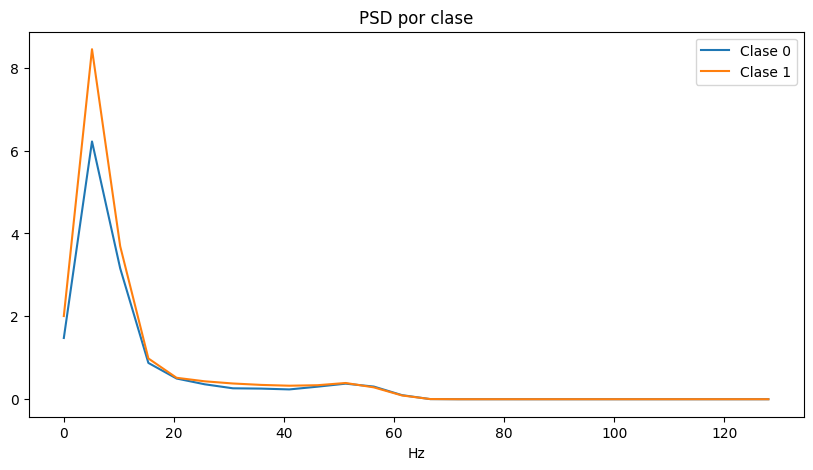

In [52]:
X_trials, y_trials = build_trial_matrix(eeg1)
X_trials = normalize_trial_lengths(X_trials)
psd_trials(X_trials, y_trials)